# Exploring Dataset

In [1]:
from datasets import get_dataset_config_names, load_dataset, DatasetDict

xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
print(
    f"XTREME has {len(panx_subsets)} PAN-X configurations | First three: {panx_subsets[:3]}"
)

XTREME has 183 configurations
XTREME has 40 PAN-X configurations | First three: ['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']


In [2]:
from collections import defaultdict

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]
# Return a DatasetDict if a key doesn't exist
panx_ch = defaultdict(DatasetDict)
for lang, frac in zip(langs, fracs):
    # Load monolingual corpus
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # Shuffle and downsample each split according to spoken proportion
    for split in ds:
        panx_ch[lang][split] = (
            ds[split].shuffle(seed=0).select(range(int(frac * ds[split].num_rows)))
        )

In [3]:
import pandas as pd

pd.DataFrame(
    {lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
    index=["Number of training examples"],
)

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [4]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(f"TAGS: {tags}")

TAGS: ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [5]:
# use int2sr to create lambda
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}


panx_de = panx_ch["de"].map(create_tag_names)

In [6]:
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]], ["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


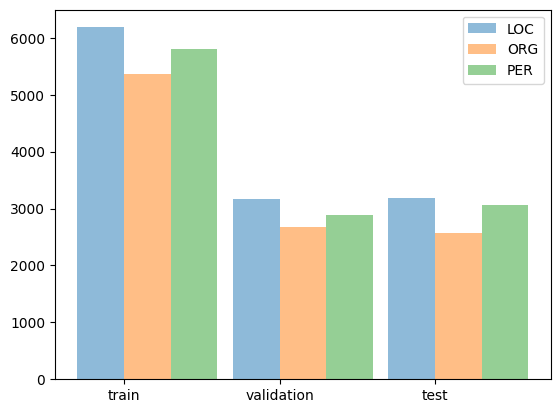

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1


tags_ = list(split2freqs["train"].keys())
splits = ["train", "validation", "test"]
width = 0.3

# Create an array with the positions of each bar along the x-axis
x = np.arange(len(splits))

for i, tag in enumerate(tags_):
    plt.bar(
        x - width / 2 + i * width,
        [split2freqs[split][tag] for split in splits],
        width,
        alpha=0.5,
        label=tag,
    )

plt.xticks(x, splits)
plt.legend()
plt.show()

# XLM RoBERTa

## Sentencepiece Tokenizer

In [8]:
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [9]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

# xlmr uses <s>, </s> for start and end of sentence instead of [CLS], [SEP]
print(f"BERT tokens: {bert_tokens}")
print(f"XLM-R tokens: {xlmr_tokens}")

# # Arabic Example
# text = "وليل كموج البحر أرخى سدوله"
# bert_tokens = bert_tokenizer(text).tokens()
# xlmr_tokens = xlmr_tokenizer(text).tokens()

# # xlmr uses <s>, </s> for start and end of sentence instead of [CLS], [SEP]
# print(f"BERT tokens: {bert_tokens}")
# print(f"XLM-R tokens: {xlmr_tokens}")

BERT tokens: ['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]']
XLM-R tokens: ['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']


# Transformers for NER (aka token classification)
for subwords, we assign the label of the first subword only and `IGN` for the rest of the subwords.

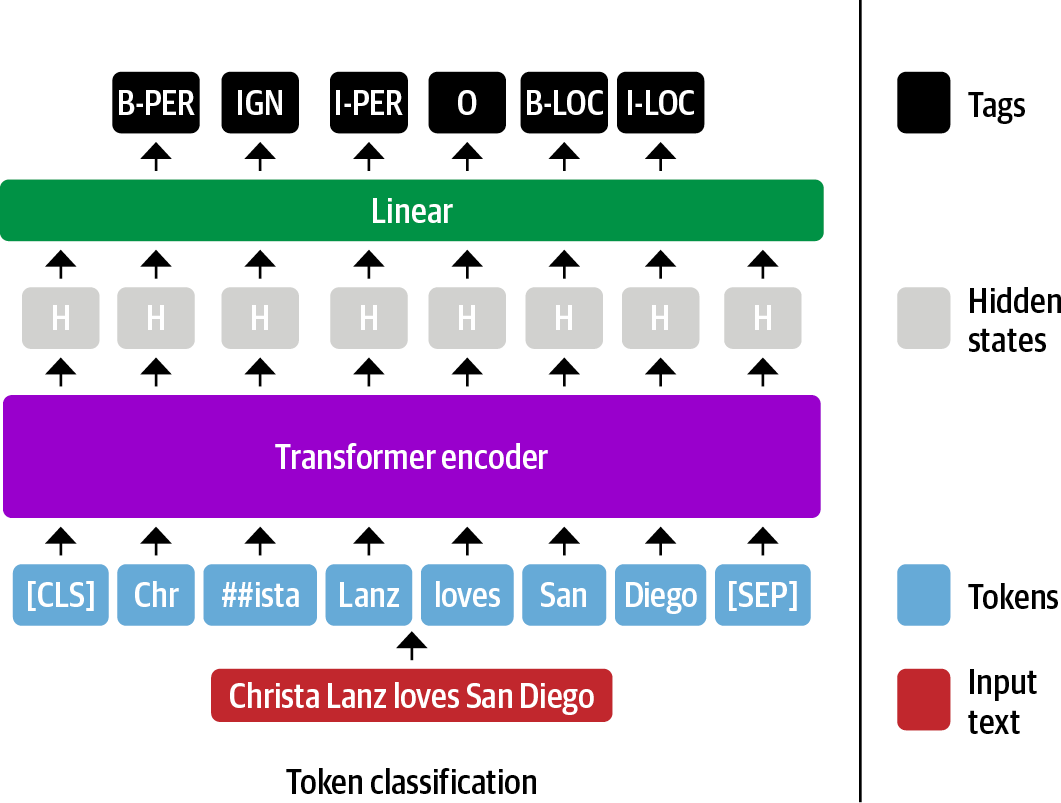

In [44]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

In [45]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False) # add_pooling_layer=False to get hidden states of all tokens not only [CLS]
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        labels=None,
        **kwargs
    ):
        # Use model body to get encoder representations
        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            **kwargs
        )
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [46]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in index2tag.items()}
print(index2tag)
# add them to config
xlmr_config = AutoConfig.from_pretrained(
    xlmr_model_name, num_labels=len(tags.names), id2label=index2tag, label2id=tag2index
)

{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [47]:
# load the model
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current CUDA device: {torch.cuda.get_device_name(torch.cuda.current_device())}")

xlmr_model = XLMRobertaForTokenClassification.from_pretrained(
    xlmr_model_name, config=xlmr_config
).to(device)

Current CUDA device: NVIDIA L4


In [48]:
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [49]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [50]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER


# Prepare for Training

In [51]:
def tag_text(text, tags, model, tokenizer):
    """
    Tags the input text with named entity recognition (NER) labels using a specified model and tokenizer.

    Parameters:
    - text (str): The input text to be tagged.
    - tags (object): An object that contains the mapping of tag indices to tag names.
                     It must have a `names` attribute that can be indexed with prediction indices.
    - model (torch.nn.Module): The NER model used for tagging. It should be a PyTorch model.
    - tokenizer (callable): The tokenizer function to tokenize the input text. It should return an object
                            with a `tokens` method that returns the list of tokens.

    Returns:
    - pd.DataFrame: A pandas DataFrame with two rows: 'Tokens' and 'Tags'. 'Tokens' contains the tokens
                    from the input text, and 'Tags' contains the corresponding NER tags predicted by the model.
    """
    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 7 possible classes
    outputs = model(input_ids)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

In [52]:
# Tokenize the dataset
words, labels = de_example["tokens"], de_example["ner_tags"]
print(f"words: {words}")
print(f"labels: {labels}")
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index=["Tokens"])

words: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
labels: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [53]:
# We need to mask subwords to avoid predicting them
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [54]:
previous_word_idx = None
label_ids = []
for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [
    index2tag[l] if l != -100 else "IGN" for l in label_ids
]  # -100 since ignored index in loss
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]
pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [55]:
# combine into one function
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [56]:
def encode_panx_dataset(corpus):
    return corpus.map(
        tokenize_and_align_labels,
        batched=True,
        remove_columns=["langs", "ner_tags", "tokens"],
    )

In [57]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

# Evaluation of NER

In [58]:
# !pip install seqeval

In [59]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"], ["B-PER", "I-PER", "O"]]
y_pred = [
    ["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
    ["B-PER", "I-PER", "O"],
]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [60]:
# take model output and convert to seqeval format (exclude subwords)
def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []
    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])
        labels_list.append(example_labels)
        preds_list.append(example_preds)
    return preds_list, labels_list

# Training the Model

In [61]:
# !pip install transformers[torch]

In [62]:
from transformers import TrainingArguments
num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"
training_args = TrainingArguments(
output_dir=model_name, log_level="error", num_train_epochs=num_epochs,
per_device_train_batch_size=batch_size,
per_device_eval_batch_size=batch_size, evaluation_strategy="epoch",
save_steps=1e6, weight_decay=0.01, disable_tqdm=False,
logging_steps=logging_steps, push_to_hub=False)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [63]:
from seqeval.metrics import f1_score
def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions,
    eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [64]:
# define collate function
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [65]:
# to init new model for every Trainer
def model_init():
    return (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device))

In [66]:
from transformers import Trainer
trainer = Trainer(model_init=model_init, args=training_args,
data_collator=data_collator, compute_metrics=compute_metrics,
train_dataset=panx_de_encoded["train"],
eval_dataset=panx_de_encoded["validation"],
tokenizer=xlmr_tokenizer)

In [67]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.259800,0.151869,0.828941
2,0.127200,0.137211,0.848591
3,0.081000,0.136840,0.861103


TrainOutput(global_step=1575, training_loss=0.15591688439959572, metrics={'train_runtime': 312.8693, 'train_samples_per_second': 120.625, 'train_steps_per_second': 5.034, 'total_flos': 862324400720376.0, 'train_loss': 0.15591688439959572, 'epoch': 3.0})

In [69]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


# Error Analysis

In [70]:
# check validation examples with highest loss
from torch.nn.functional import cross_entropy
def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model
        output = trainer.model(input_ids, attention_mask)
        # logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 7),
    labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()
    return {"loss":loss, "predicted_label": predicted_label}

In [71]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [72]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.020354442, 0.0, 0.02647356, 0.02202292...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [73]:
# better visualization
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.02,B-ORG,▁Ham
0,15,1,I-ORG,0.03,I-ORG,▁(
0,16104,1,I-ORG,0.02,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.02,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,1.14,B-LOC,▁Luz
1,10,1,I-ORG,1.18,I-LOC,▁a


In [78]:
# tokens with highest loss: whitespaces, stopw
df_tokens.groupby("input_tokens")[["loss"]].agg(["count", "mean", "sum"]).droplevel(level=0, axis=1).sort_values(by="sum", ascending=False).reset_index().round(2).head(10).T

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁der,▁in,▁von,▁/,▁und,▁'',▁(,▁),▁A
count,6066,1388,989,808,163,1171,2898,246,246,125
mean,0.04,0.09,0.13,0.15,0.54,0.07,0.03,0.28,0.26,0.44
sum,215.93,127.11,125.19,122.82,87.89,87.66,75.56,68.35,64.75,55.61


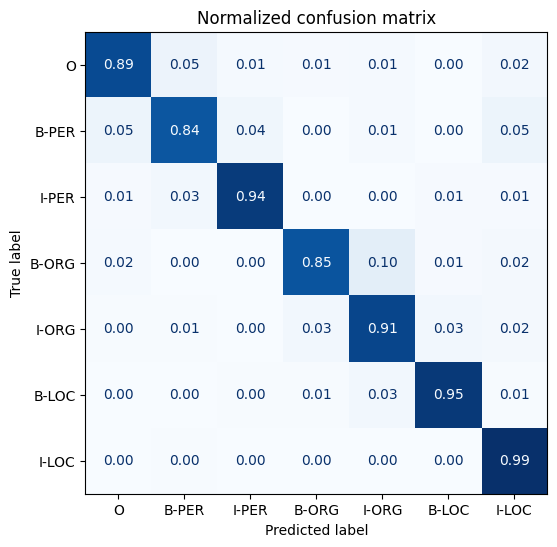

In [79]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
tags.names)

# Cross Lingual Transfer

In [80]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [81]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

F1-score of [de] model on [de] dataset: 0.862


In [82]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


In [83]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])

f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")


Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

F1-score of [de] model on [fr] dataset: 0.703
